In [1]:
## Mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import glob
import re, string
import matplotlib.pyplot as plt


# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn - Model & Preprocessing
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,f1_score

In [3]:
## Load the trainig Data
folder_path = "/paste_your_path/train/*.parquet"
files = glob.glob(folder_path)
com_train_df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)

print(com_train_df.shape)
com_train_df.head()

(229624, 23)


,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,1560986322,Vintage Ashtray with Lid Outdoor Metal Ashtra...,Vintage Ashtray with Lid\n\nOutdoor Metal Asht...,"metal ashtray,small ashtray,vintage ashtray,as...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,16,silver,1,black
1,883804799,Skull ashtray and lighter holder storage box,Crane Removable Ashtray\n\nWe turn the ashtray...,,physical,,,,,bachelor party,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,14,red
2,1591576592,Take A Chill Pill Ashtray | Ashtray Patrick Tr...,Add some psychedelic style to your smoking rou...,,physical,,,,,birthday,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,11,pink,13,rainbow
3,1594034745,Wedgwood Willow Ashtray Trinket Pin Dish - Vin...,Wedgwood Willow Ashtray\n\nCould be used as a ...,"Wedgwood Porcelain,Willow Pattern,Trinket Pin ...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,2,blue
4,1570189167,Vintage Floral Hand Painted Italian Ashtrays f...,Collectible Set of 2 rare Italian Floral Hand ...,"Hexagon ashtray,vintage ashtray,Italian ashtra...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,2,blue


**Exploratory Data Analysis (EDA)**

In [13]:
# Check data types
print(com_train_df.dtypes)

# Descriptive statistics for numerical columns
# print(com_train_df.describe())


product_id               int64
title                   object
description             object
tags                    object
type                    object
room                    object
craft_type              object
recipient               object
material                object
occasion                object
holiday                 object
art_subject             object
style                   object
shape                   object
pattern                 object
bottom_category_id       int64
bottom_category_text    object
top_category_id          int64
top_category_text       object
primary_color_id         int64
primary_color_text      object
secondary_color_id       int64
secondary_color_text    object
dtype: object


In [4]:
## Checking Missing Values
miss_col = com_train_df.isna().sum()

miss_val = pd.DataFrame({
    'Missing Values':miss_col.values,
    'Missing Percentage':round((miss_col/com_train_df.shape[0]) *100, 2).astype(str) + '%',
    'Column Datatype':com_train_df.dtypes
})

miss_val.sort_values(by='Missing Percentage', ascending=False)

,Missing Values,Missing Percentage,Column Datatype
product_id,0,0.0%,int64
style,0,0.0%,object
secondary_color_id,0,0.0%,int64
primary_color_text,0,0.0%,object
primary_color_id,0,0.0%,int64
top_category_text,0,0.0%,object
top_category_id,0,0.0%,int64
bottom_category_text,0,0.0%,object
bottom_category_id,0,0.0%,int64
pattern,0,0.0%,object


In [5]:
# Check unique values for each column
for col in com_train_df.columns:
  print(f'Unique value in {col} - {com_train_df[col].nunique()}')

Unique value in product_id - 229624
Unique value in title - 224252
Unique value in description - 216129
Unique value in tags - 185370
Unique value in type - 3
Unique value in room - 19
Unique value in craft_type - 78
Unique value in recipient - 26
Unique value in material - 77
Unique value in occasion - 63
Unique value in holiday - 21
Unique value in art_subject - 40
Unique value in style - 93
Unique value in shape - 49
Unique value in pattern - 41
Unique value in bottom_category_id - 2609
Unique value in bottom_category_text - 2609
Unique value in top_category_id - 15
Unique value in top_category_text - 15
Unique value in primary_color_id - 19
Unique value in primary_color_text - 19
Unique value in secondary_color_id - 19
Unique value in secondary_color_text - 19


In [6]:
# com_train_df['material'].value_counts()
com_train_df['type'].value_counts()

,count
type,
physical,218568
download,10708
,348


##### Class Imbalance Obervation

In [8]:
"""
  top_category_id: the primary, high-level category under which a product is listed.
  For example, a product might fall under "Art & Collectibles," which would be its top category.​

  bottom_category_id: more specific, granular subcategory within the top category.
  For instance, within "Art & Collectibles," there could be a subcategory like "Tobacciana Ashtrays," which would be the bottom category.​
"""

"""
    Comment on class imbalance:
    The top category ('home_and_living') has almost 10x more samples than the least populated category ('pet_supplies').
    This significant difference in sample size across categories indicates a clear class imbalance,
    which can affect model performance by biasing predictions toward majority classes.
"""

com_train_df[['top_category_id','top_category_text']].value_counts()

,,count
top_category_id,top_category_text,
8,home_and_living,54600
6,craft_supplies_and_tools,33393
5,clothing,30143
13,toys_and_games,13835
0,accessories,12416
10,paper_and_party_supplies,12207
3,bath_and_beauty,11327
14,weddings,10143
12,shoes,8892


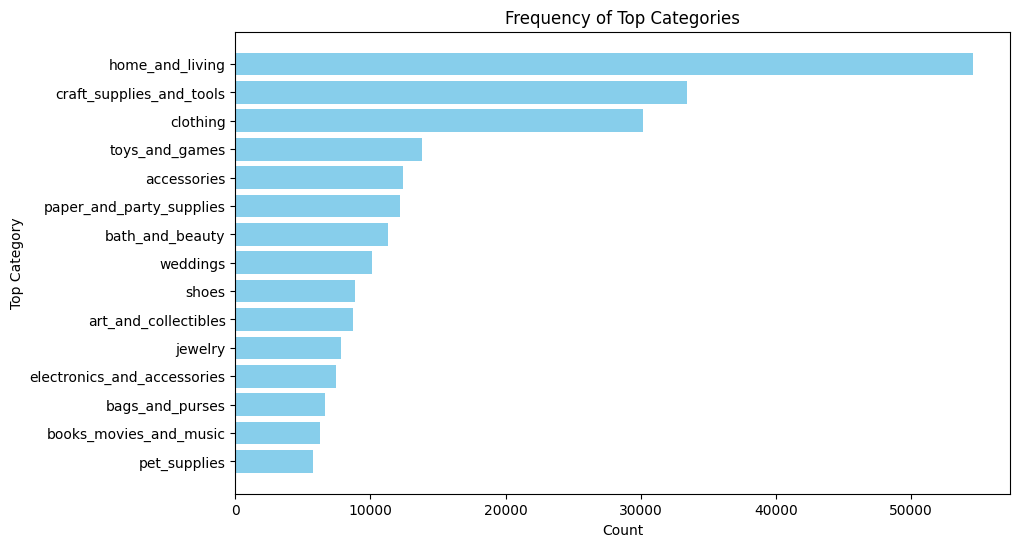

In [9]:
category_counts = com_train_df[['top_category_id', 'top_category_text']].value_counts()
category_counts = category_counts.reset_index(name='count')
category_counts = category_counts.sort_values(by='count', ascending=False)

# Bar Graph for Top Category Text
plt.figure(figsize=(10, 6))
plt.barh(category_counts['top_category_text'], category_counts['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Top Category')
plt.title('Frequency of Top Categories')
plt.gca().invert_yaxis()
plt.show()

In [10]:
"""
  The class imbalance in the target variable, with the most common class
  ("weddings.shoes.womens_wedding_shoes") appearing 98 times and the
  least common class ("accessories") appearing 42 times
"""

com_train_df['bottom_category_text'].value_counts().reset_index().min()

,0
bottom_category_text,accessories
count,42


In [11]:
com_train_df['bottom_category_text'].value_counts().reset_index().max()

,0
bottom_category_text,weddings.shoes.womens_wedding_shoes
count,98


**Text Pre Processing**

In [17]:
# --- Download NLTK Resources ---
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# --- Initialize NLTK Tools ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- Text Cleaning Function ---
def clean_text(text):
    """
    Function to clean and preprocess text data. It performs the following operations:
    1. Converts text to lowercase.
    2. Removes punctuation and newlines.
    3. Tokenizes the text into words.
    4. Removes stop words.
    5. Lemmatizes the words.
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase, remove punctuation, newlines, and extra spaces
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize text and remove stop words
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(lemmatized_tokens)

# --- Clean Text Data (Title + Description + Tags) ---
com_train_df['text_clean'] = (
                            com_train_df['title'].fillna('') + " " +
                            com_train_df['description'].fillna('') + " " +
                            com_train_df['tags'].fillna('')
                        ).apply(lambda x: clean_text(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
### Top 20 most common words for each top-level category
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

top_category_column = 'top_category_id'
stop_words = set(stopwords.words('english'))


def get_top_words_by_category(df, top_category_column):
    category_word_counts = {}
    for category, group in df.groupby(top_category_column):
        text = " ".join(group['text_clean'])

        # Tokenize the text into individual words
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        word_counts = Counter(tokens)

        top_words = word_counts.most_common(20)
        category_word_counts[category] = top_words

    return category_word_counts

# Generate top words for each category using the above function
top_words_by_category = get_top_words_by_category(com_train_df, top_category_column)

"""
  Manually explored the most frequent words in each category to investigate
  potential differences in language usage that could guide model optimization.
  However, no significant or consistent patterns were identified that could be
  leveraged to improve or tweak the model.
"""
# Display the top 20 words for each top-level category along with their frequencies
for category, top_words in top_words_by_category.items():
    print(f"Top words for category: {category}")
    for word, count in top_words:
        print(f"{word}: {count}")
    print("\n")

Top words for category: 0
n: 92764
hat: 25634
gift: 14271
39: 14111
quot: 12426
hair: 10135
made: 9354
size: 8403
please: 8378
tie: 8362
glove: 8243
item: 8192
vintage: 7875
hand: 7174
day: 7158
shop: 6994
order: 6782
1: 6479
black: 6287
accessory: 6269


Top words for category: 1
n: 55389
art: 17639
quot: 13284
print: 11012
gift: 7895
39: 7759
vintage: 6780
wall: 6192
x: 6158
painting: 6042
decor: 5237
glass: 5176
please: 5052
original: 5034
item: 4957
1: 4937
size: 4377
5: 4203
made: 4121
hand: 4040


Top words for category: 2
n: 54773
bag: 38470
gift: 11307
quot: 9976
leather: 7318
39: 6603
case: 6452
travel: 5917
x: 5675
fabric: 5221
item: 5171
wallet: 5134
made: 4796
cm: 4765
vintage: 4719
5: 4255
pocket: 4234
purse: 4184
strap: 4058
luggage: 3927


Top words for category: 3
n: 128670
oil: 22844
gift: 15626
hair: 13710
nail: 13396
skin: 13231
39: 12513
use: 12092
product: 11641
bottle: 11457
free: 10371
natural: 9618
quot: 8197
item: 8075
made: 7531
plastic: 7188
1: 7166
black: 69

In [19]:
# --- Label Encoding for Target Variables ---
le_top = LabelEncoder()
le_bottom = LabelEncoder()
com_train_df['top_enc'] = le_top.fit_transform(com_train_df['top_category_id'])
com_train_df['bottom_enc'] = le_bottom.fit_transform(com_train_df['bottom_category_id'])

In [20]:
# --- Prepare Feature Columns ---
text_features = ['text_clean']
cat_features = ['type', 'room', 'craft_type', 'recipient', 'material', 'occasion',
                'holiday', 'art_subject', 'style', 'shape', 'pattern']
"""
  We cannot include the primary_color_id and secondary_color_id columns in the
  categorical features, as these columns are not present in the test datasets.
  Including them would result in poor model performance.
"""

'\n  We cannot include the primary_color_id and secondary_color_id columns in the \n  categorical features, as these columns are not present in the test datasets.\n  Including them would result in poor model performance.\n'

In [21]:
# --- Define Features and Target Variables ---
X_cat = com_train_df[cat_features]
X_text = com_train_df['text_clean']
y_top = com_train_df['top_enc']
y_bottom = com_train_df['bottom_enc']

# --- Split Data into Training and Validation Sets ---
X_cat_train, X_cat_val, X_text_train, X_text_val, y_top_train, y_top_val, y_bottom_train, y_bottom_val = train_test_split(
    X_cat, X_text, y_top, y_bottom, test_size=0.2, random_state=42
)


In [24]:
 # One-Hot Encoding for Categorical Features ---
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat_train_enc = ohe.fit_transform(X_cat_train)
X_cat_val_enc = ohe.transform(X_cat_val)

In [25]:
# --- TF-IDF Vectorization for Text Features ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_text_train_vec = tfidf.fit_transform(X_text_train)
X_text_val_vec = tfidf.transform(X_text_val)

In [26]:
# --- Combine Text and Categorical Features ---
X_train_comb = hstack([X_text_train_vec, X_cat_train_enc])
X_val_comb = hstack([X_text_val_vec, X_cat_val_enc])

## Models

**Logistic Regression**

In [27]:
# --- Model 1: Predict Top Category ---
clf_top = LogisticRegression(solver='saga', max_iter=500, class_weight='balanced')
clf_top.fit(X_train_comb, y_top_train)
y_top_pred = clf_top.predict(X_val_comb)

# Print classification report for top category prediction
print("\n📊 Top Category Classification:")
print(classification_report(y_top_val, y_top_pred))

# Calculate and print F1 score for top category
f1_top = f1_score(y_top_val, y_top_pred, average='weighted')
print(f"✅ Weighted F1 Score (Top Category): {f1_top:.4f}")


📊 Top Category Classification:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2475
           1       0.61      0.78      0.69      1706
           2       0.76      0.88      0.81      1371
           3       0.81      0.89      0.85      2249
           4       0.78      0.91      0.84      1226
           5       0.97      0.93      0.95      5994
           6       0.94      0.86      0.90      6775
           7       0.80      0.91      0.85      1513
           8       0.93      0.82      0.87     10930
           9       0.85      0.91      0.88      1539
          10       0.80      0.86      0.83      2456
          11       0.87      0.94      0.91      1171
          12       0.94      0.96      0.95      1780
          13       0.82      0.84      0.83      2786
          14       0.67      0.69      0.68      1954

    accuracy                           0.86     45925
   macro avg       0.82      0.87      0.84     

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
# --- Model 2: Predict Bottom Category (Conditional on Top Category Prediction) ---
bottom_preds = []
bottom_models = {}

for idx, top_label in enumerate(y_top_pred):
    # Check if model for the top category already exists
    if top_label not in bottom_models:
        indices = np.where(y_top_train == top_label)[0]
        if len(indices) < 10:  # not enough data
            bottom_models[top_label] = None
            continue
        model = LogisticRegression(solver='saga', max_iter=500, class_weight='balanced')
        model.fit(X_train_comb[indices], y_bottom_train.iloc[indices])
        bottom_models[top_label] = model

    # Make bottom category prediction
    model = bottom_models[top_label]
    if model:
        bottom_preds.append(model.predict(X_val_comb[idx])[0])
    else:
        bottom_preds.append(np.random.choice(y_bottom_train))  # Fallback if model not found

# Print classification report for bottom category prediction
print("\n📊 Bottom Category Classification:")
print(classification_report(y_bottom_val, bottom_preds))

# Calculate and print F1 score for bottom category
f1_bottom = f1_score(y_bottom_val, bottom_preds, average='weighted')
print(f"✅ Weighted F1 Score (Bottom Category): {f1_bottom:.4f}")


📊 Bottom Category Classification:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.50      0.36      0.42        14
           2       0.72      1.00      0.84        13
           3       0.47      0.58      0.52        12
           4       0.87      0.81      0.84        16
           5       0.27      0.20      0.23        15
           6       0.84      0.64      0.73        25
           7       0.78      0.67      0.72        21
           8       0.37      0.62      0.47        16
           9       0.11      0.27      0.15        11
          10       1.00      0.71      0.83        21
          11       1.00      0.40      0.57        15
          12       0.71      0.67      0.69        15
          13       0.76      0.89      0.82        18
          14       0.94      1.00      0.97        16
          15       0.12      0.06      0.08        17
          16       0.40      0.47      0.43        17
          17       0.79    

In [30]:
# 💾 Save models and encoders for later use

import joblib

joblib.dump(clf_top, "/paste_your_path/clf_top_model_lg.pkl")
joblib.dump(bottom_models, "/paste_your_path/clf_bottom_models_lg.pkl")
joblib.dump(le_top, "/paste_your_path/label_encoder_top_lg.pkl")
joblib.dump(le_bottom, "/paste_your_path/label_encoder_bottom_lg.pkl")
joblib.dump(ohe, "/paste_your_path/onehot_encoder_lg.pkl")
joblib.dump(tfidf, "/paste_your_path/tfidf_vectorizer_lg.pkl")

['/content/drive/MyDrive/machine_learning/project/tfidf_vectorizer_lg.pkl']

**Linear SVC**

In [42]:
# 🧠 Model 1: Predict Top Category using LinearSVC
clf_top = LinearSVC(max_iter=1000, class_weight='balanced')
clf_top.fit(X_train_comb, y_top_train)
y_top_pred = clf_top.predict(X_val_comb)

print("\n📊 Top Category Classification:")
print(classification_report(y_top_val, y_top_pred))

# ✅ F1 Score for Top Category
f1_top = f1_score(y_top_val, y_top_pred, average='weighted')
print(f"✅ Weighted F1 Score (Top Category): {f1_top:.4f}")


📊 Top Category Classification:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2475
           1       0.68      0.73      0.70      1706
           2       0.78      0.88      0.83      1371
           3       0.84      0.89      0.86      2249
           4       0.80      0.88      0.84      1226
           5       0.96      0.95      0.95      5994
           6       0.93      0.90      0.91      6775
           7       0.85      0.90      0.88      1513
           8       0.91      0.86      0.89     10930
           9       0.85      0.92      0.88      1539
          10       0.82      0.85      0.83      2456
          11       0.89      0.94      0.91      1171
          12       0.94      0.97      0.95      1780
          13       0.82      0.83      0.82      2786
          14       0.70      0.68      0.69      1954

    accuracy                           0.87     45925
   macro avg       0.84      0.86      0.85     

In [43]:
# 🧠 Model 2: Predict Bottom Category Hierarchically using LinearSVC
bottom_preds = []
bottom_models = {}

for idx, top_label in enumerate(y_top_pred):
    if top_label not in bottom_models:
        indices = np.where(y_top_train == top_label)[0]
        if len(indices) < 10:  # not enough data
            bottom_models[top_label] = None
            continue
        model = LinearSVC(max_iter=1000, class_weight='balanced')
        model.fit(X_train_comb[indices], y_bottom_train.iloc[indices])
        bottom_models[top_label] = model

    model = bottom_models[top_label]
    if model:
        bottom_preds.append(model.predict(X_val_comb[idx])[0])
    else:
        bottom_preds.append(np.random.choice(y_bottom_train))  # fallback

print("\n📊 Bottom Category Classification:")
print(classification_report(y_bottom_val, bottom_preds))

# ✅ F1 Score for Bottom Category
f1_bottom = f1_score(y_bottom_val, bottom_preds, average='weighted')
print(f"✅ Weighted F1 Score (Bottom Category): {f1_bottom:.4f}")


📊 Bottom Category Classification:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.20      0.08      0.11        13
           1       0.62      0.57      0.59        14
           2       0.71      0.92      0.80        13
           3       0.47      0.58      0.52        12
           4       0.88      0.94      0.91        16
           5       0.43      0.20      0.27        15
           6       0.86      0.72      0.78        25
           7       0.71      0.81      0.76        21
           8       0.56      0.56      0.56        16
           9       0.20      0.45      0.28        11
          10       1.00      0.67      0.80        21
          11       0.90      0.60      0.72        15
          12       0.83      0.67      0.74        15
          13       0.75      0.83      0.79        18
          14       0.94      1.00      0.97        16
          15       0.38      0.29      0.33        17
          16       0.40      0.35      0.38        17
          17       0.83    

In [44]:
# 💾 Save models and encoders for later use

import joblib

joblib.dump(clf_top, "/paste_your_path/clf_top_model_lSVC.pkl")
joblib.dump(bottom_models, "/paste_your_path/clf_bottom_models_lSVC.pkl")
joblib.dump(le_top, "/paste_your_path/label_encoder_top_lSVC.pkl")
joblib.dump(le_bottom, "/paste_your_path/label_encoder_bottom_lSVC.pkl")
joblib.dump(ohe, "/paste_your_path/onehot_encoder_lSVC.pkl")
joblib.dump(tfidf, "/paste_your_path/tfidf_vectorizer_lSVC.pkl")

['/content/drive/MyDrive/machine_learning/project/tfidf_vectorizer_lSVC.pkl']

**Running on Testing Folder**

In [45]:
# --- Load Test Data ---
test_folder_path = "/paste_your_path/test/*.parquet"
test_files = glob.glob(test_folder_path)
com_test_df = pd.concat([pd.read_parquet(file) for file in test_files], ignore_index=True)

In [46]:
# --- Load Pre-trained Models and Encoders ---
clf_top = joblib.load("/paste_your_path/clf_top_model_lSVC.pkl")
bottom_models = joblib.load("/paste_your_path/clf_bottom_models_lSVC.pkl")
le_top = joblib.load("/paste_your_path/label_encoder_top_lSVC.pkl")
le_bottom = joblib.load("/paste_your_path/label_encoder_bottom_lSVC.pkl")
ohe = joblib.load("/paste_your_path/onehot_encoder_lSVC.pkl")
tfidf = joblib.load("/paste_your_path/tfidf_vectorizer_lSVC.pkl")

In [47]:
com_test_df['text_clean'] = (
    com_test_df['title'].fillna('') + " " +
    com_test_df['description'].fillna('') + " " +
    com_test_df['tags'].fillna('')
).apply(clean_text)

In [48]:
com_test_df[cat_features] = com_test_df[cat_features].fillna("unknown")

In [49]:
# --- Encode Features ---
X_text_test_vec = tfidf.transform(com_test_df['text_clean'])
X_cat_test_enc = ohe.transform(com_test_df[cat_features])
X_test_comb = hstack([X_text_test_vec, X_cat_test_enc])

In [50]:
# --- Predict Top Category ---
y_top_pred_test_enc = clf_top.predict(X_test_comb)
y_top_pred_test = le_top.inverse_transform(y_top_pred_test_enc)

In [51]:
# --- Predict Bottom Category ---
bottom_preds = []
for idx, top_label_enc in enumerate(y_top_pred_test_enc):
    model = bottom_models.get(top_label_enc)
    if model:
        bottom_pred_enc = model.predict(X_test_comb[idx])
    else:
        bottom_pred_enc = [np.random.choice(le_bottom.classes_)]
    bottom_preds.append(bottom_pred_enc[0])

In [52]:
# Convert encoded bottom preds to labels
y_bottom_pred_test = le_bottom.inverse_transform(bottom_preds)

In [53]:
# --- Save Prediction Output ---
output_df = pd.DataFrame({
    'product_id': com_test_df['product_id'],
    'top_category_id': y_top_pred_test,
    'bottom_category_id': y_bottom_pred_test
})

output_df.to_parquet("/paste_your_path/test_predictions.parquet", index=False)
print("✅ Predictions saved successfully!")

✅ Predictions saved successfully!


In [54]:
output_df.to_csv("/paste_your_path/test_predictions.csv", index=False)

**BERT + Neural Network**

#### We can switch to the BERT fine-tuning approach by simply setting USE_FINE_TUNED_BERT = True in the code.

In [3]:
## Import Required Libraries
import os
import glob
import numpy as np
import pandas as pd

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Configuration
USE_FINE_TUNED_BERT = False   ## To run fine tune bert in the future
BERT_MODEL_NAME = 'all-MiniLM-L6-v2'   ## pre-trained Sentence-BERT model used for text embedding

# File path to save/load pre-computed BERT embeddings to avoid redundant computation
bert_cache_path = "/paste_your_path/bert_embeddings.npy"

## For Fine-Tuned Bert
input_ids_path = '/paste_your_path/input_ids.pt'
attention_mask_path = '/paste_your_path/attention_mask.pt'


In [5]:
# Load com Dataset
folder_path = "/paste_your_path/train/*.parquet"
files = glob.glob(folder_path)
com_train_df = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
print(com_train_df.shape)
com_train_df.head()

(229624, 23)


,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,shape,pattern,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text
0,1560986322,Vintage Ashtray with Lid Outdoor Metal Ashtra...,Vintage Ashtray with Lid\n\nOutdoor Metal Asht...,"metal ashtray,small ashtray,vintage ashtray,as...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,16,silver,1,black
1,883804799,Skull ashtray and lighter holder storage box,Crane Removable Ashtray\n\nWe turn the ashtray...,,physical,,,,,bachelor party,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,14,red
2,1591576592,Take A Chill Pill Ashtray | Ashtray Patrick Tr...,Add some psychedelic style to your smoking rou...,,physical,,,,,birthday,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,11,pink,13,rainbow
3,1594034745,Wedgwood Willow Ashtray Trinket Pin Dish - Vin...,Wedgwood Willow Ashtray\n\nCould be used as a ...,"Wedgwood Porcelain,Willow Pattern,Trinket Pin ...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,2,blue
4,1570189167,Vintage Floral Hand Painted Italian Ashtrays f...,Collectible Set of 2 rare Italian Floral Hand ...,"Hexagon ashtray,vintage ashtray,Italian ashtra...",physical,,,,,,...,,,1868,art_and_collectibles.collectibles.tobacciana.a...,1,art_and_collectibles,17,white,2,blue


#### Text PreProcessing

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply text cleaning to title, description, and tags
text_data = com_train_df.apply(lambda row: clean_text(str(row['title']) + " " +
                                                 str(row['description']) + " " +
                                                 str(row['tags'])), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
# Handle Categorical Features
"""
  We cannot include the primary_color_id and secondary_color_id columns in the
  categorical features, as these columns are not present in the test datasets.
  Including them would result in poor model performance.
"""

cat_features = ['type', 'room', 'craft_type', 'recipient', 'material',
                'occasion', 'holiday', 'art_subject', 'style', 'shape', 'pattern']
com_train_df[cat_features] = com_train_df[cat_features].fillna("unknown")


In [8]:
# Encode Top & Bottom Category Labels
le_top = LabelEncoder()
le_bottom = LabelEncoder()

# Fit the encoders on the training set and transform category IDs into integer labels
com_train_df['top_enc'] = le_top.fit_transform(com_train_df['top_category_id'])
com_train_df['bottom_enc'] = le_bottom.fit_transform(com_train_df['bottom_category_id'])

# Convert the encoded labels from the full dataset into PyTorch tensors for model training
y_top = torch.tensor(com_train_df['top_enc'].values)
y_bottom = torch.tensor(com_train_df['bottom_enc'].values)

In [9]:
# Compute Class Weights
"""
  Class weights help handle class imbalance during model training by assigning
  higher importance to underrepresented categories.
"""

from collections import Counter

def compute_class_weights(labels_tensor, num_classes):
    counts = Counter(labels_tensor.numpy())
    weights = [1.0 / counts[i] if i in counts else 0 for i in range(num_classes)]

    # Convert to tensor and normalize the weights so they sum to 1
    weights = torch.tensor(weights, dtype=torch.float32)
    return weights / weights.sum()


top_weights = compute_class_weights(y_top, len(le_top.classes_))
bottom_weights = compute_class_weights(y_bottom, len(le_bottom.classes_))

In [10]:
# TEXT FEATURES: Generate or Load BERT Embeddings

# This block handles text feature extraction using Sentence-BERT embeddings
# or pretrained BERT tokenization based on the configuration flag.
# Embeddings/tokenized outputs are cached for efficiency in future runs.

if not USE_FINE_TUNED_BERT:
    # Use Sentence-BERT Embeddings
    if os.path.exists(bert_cache_path):
        print("✅ Loading cached BERT embeddings...")
        # Load pre-computed embeddings from disk
        X_text = torch.tensor(np.load(bert_cache_path)).float()
    else:
        print("⏳ Encoding text with Sentence-BERT...")
        # Generate sentence embeddings using pre-trained model
        model_bert = SentenceTransformer(BERT_MODEL_NAME)
        X_text_np = model_bert.encode(text_data.tolist(), batch_size=64, show_progress_bar=True)

        # Save to disk for reuse
        np.save(bert_cache_path, X_text_np)
        X_text = torch.tensor(X_text_np).float()

else:
    # Use Pretrained BERT Tokenizer (no fine-tuning)
    print('🧠 Using Pretrained BERT Tokenizer')

    if os.path.exists(input_ids_path) and os.path.exists(attention_mask_path):
        print("✅ Loading cached tokenized BERT data...")
        # Load previously tokenized inputs
        input_ids = torch.load(input_ids_path)
        attention_mask = torch.load(attention_mask_path)
    else:
        print("⏳ Tokenizing text with BERT in batches (memory safe)...")
        from transformers import AutoTokenizer
        import gc

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

        input_ids_list = []
        attention_mask_list = []

        batch_size = 512  # Adjust depending on memory constraints

        # Tokenize in batches to avoid memory overload
        for i in range(0, len(text_data), batch_size):
            batch = text_data[i:i+batch_size].tolist()
            tokenized = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            input_ids_list.append(tokenized["input_ids"])
            attention_mask_list.append(tokenized["attention_mask"])

            # Cleanup to free memory
            del tokenized, batch
            gc.collect()
        # Concatenate all batches
        input_ids = torch.cat(input_ids_list, dim=0)
        attention_mask = torch.cat(attention_mask_list, dim=0)

        # Save tokenized results for reuse
        torch.save(input_ids, input_ids_path)
        torch.save(attention_mask, attention_mask_path)

        print("✅ Tokenized BERT data saved successfully!")


✅ Loading cached BERT embeddings...


In [11]:
# CATEGORICAL FEATURES: One-Hot Encoding & Merge

# This block encodes categorical features using One-Hot Encoding.
# The resulting encoded features are combined with text embeddings
# (if fine-tuned BERT is not used) to form the final feature matrix.

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = torch.tensor(ohe.fit_transform(com_train_df[cat_features])).float()

# If we're not using tokenized BERT input, concatenate text and categorical features
if not USE_FINE_TUNED_BERT:
    X = torch.cat([X_text, X_cat], dim=1)  # Merge BERT embeddings with one-hot encoded categorical data


In [12]:
# To clear the cache variables
import gc
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
# Custom Dataset Class for com Product Classification
"""
  This dataset handles both BERT-based and combined feature inputs.
  It supports hierarchical multi-label classification (top & bottom categories).
"""
class comDataset(Dataset):
    def __init__(self, X_text, X_cat, y_top, y_bottom, input_ids=None, attention_mask=None):

        self.X_text = X_text
        self.X_cat = X_cat
        self.y_top = y_top
        self.y_bottom = y_bottom
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return len(self.y_top)

    def __getitem__(self, idx):
        """
        Return a single sample from the dataset.

        If using fine-tuned BERT, return input_ids and attention_mask
        along with categorical features and labels.
        Otherwise, return concatenated BERT embeddings and categorical features.
        """
        if USE_FINE_TUNED_BERT:
            return {
                'input_ids': self.input_ids[idx],
                'attention_mask': self.attention_mask[idx],
                'cat_feats': self.X_cat[idx],
                'y_top': self.y_top[idx],
                'y_bottom': self.y_bottom[idx]
            }
        else:
            # Concatenate BERT text embeddings and one-hot categorical features
            full_input = torch.cat([self.X_text[idx], self.X_cat[idx]], dim=0)
            return full_input, self.y_top[idx], self.y_bottom[idx]


In [14]:
# Hierarchical Multi-Label Classification Model

"""
  This model predicts both top-level and bottom-level product categories.
  It supports both precomputed BERT embeddings and fine-tuned BERT input.
"""

from transformers import AutoModel

class HierarchicalClassifier(nn.Module):
    def __init__(self, cat_dim, n_top, n_bottom):
        """
          cat_dim (int): Dimension of the one-hot encoded categorical features.
          n_top (int): Number of unique top-level categories.
          n_bottom (int): Number of unique bottom-level categories.
        """
        super().__init__()

        if USE_FINE_TUNED_BERT:
            # Load pretrained BERT model and project its output with categorical features
            self.bert = AutoModel.from_pretrained("bert-base-uncased")
            self.text_fc = nn.Linear(768 + cat_dim, 256)
        else:
            # If not using fine-tuned BERT, directly project combined features
            self.text_fc = nn.Linear(X.shape[1], 256)

        # Shared hidden representation between top and bottom classifiers
        self.shared = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Classifier head for top-level categories
        self.top_head = nn.Linear(128, n_top)

        # Classifier head for bottom-level categories, conditioned on top-level predictions
        self.bottom_head = nn.Linear(128 + n_top, n_bottom)

    def forward(self, xb_text=None, cat_feats=None, input_ids=None, attention_mask=None):
        """
        Forward pass of the model
        Args:
            xb_text (Tensor): Precomputed text embeddings (used if not fine-tuned BERT).
            cat_feats (Tensor): One-hot encoded categorical features.
            input_ids (Tensor): BERT token IDs (used if fine-tuned BERT).
            attention_mask (Tensor): BERT attention masks.

        Returns:
            top_logits (Tensor): Logits for top-level categories.
            bottom_logits (Tensor): Logits for bottom-level categories.
            shared (Tensor): Shared feature representation.
        """
        if USE_FINE_TUNED_BERT:
            # Use fine-tuned BERT output (pooled) and concatenate with categorical features
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
            x = torch.cat([bert_out, cat_feats], dim=1)
            x = self.text_fc(x)
        else:
            # Use precomputed BERT + categorical features
            x = self.text_fc(xb_text)

        # Shared intermediate representation
        shared = self.shared(x)

        # Top category prediction
        top_logits = self.top_head(shared)
        top_probs = F.softmax(top_logits, dim=1)

        # Bottom category prediction, conditioned on top category
        combined = torch.cat([shared, top_probs], dim=1)
        bottom_logits = self.bottom_head(combined)

        return top_logits, bottom_logits, shared


In [15]:
#  DATA SPLITTING

# Create the dataset instance depending on whether fine-tuned BERT is used
if USE_FINE_TUNED_BERT:
    # Use tokenized input_ids and attention_mask for BERT-based dataset
    dataset = comDataset(
        input_ids=input_ids,
        attention_mask=attention_mask,
        X_text=None,  # Not needed when using fine-tuned BERT
        X_cat=X_cat,
        y_top=y_top,
        y_bottom=y_bottom
    )
else:
    # Use precomputed BERT embeddings + categorical features
    dataset = comDataset(
        X_text,
        X_cat,
        y_top,
        y_bottom
    )

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_ds, batch_size=32)


In [19]:
def train_model(model, train_ds, val_ds, num_epochs=5):
    # Set the model to training mode
    model.train()

    # Define loss functions for both top and bottom category predictions
    criterion_top = nn.CrossEntropyLoss(weight=top_weights.to(device))  # For top category
    criterion_bottom = nn.CrossEntropyLoss(weight=bottom_weights.to(device))  # For bottom category

    # Initialize the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader instances for training and validation datasets
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

    # Initialize variables to track the best validation loss and model state
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_path = ''


    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()

            # If using fine-tuned BERT
            if USE_FINE_TUNED_BERT:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                cat_feats = batch['cat_feats'].to(device)
                y_top = batch['y_top'].to(device)
                y_bottom = batch['y_bottom'].to(device)

                # Forward pass through the model
                top_logits, bottom_logits, _ = model(input_ids=input_ids, attention_mask=attention_mask, cat_feats=cat_feats)
            else:
                # If not using fine-tuned BERT, use precomputed embeddings
                xb, y_top, y_bottom = batch
                xb = xb.to(device)
                y_top = y_top.to(device)
                y_bottom = y_bottom.to(device)

                # Forward pass through the model
                top_logits, bottom_logits, _ = model(xb)

            # Compute loss for both top and bottom categories
            loss = criterion_top(top_logits, y_top) + criterion_bottom(bottom_logits, y_bottom)
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            #clear_memory()

        # Validation phase
        print('Validation')
        model.eval()
        val_loss = 0.0

        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                if USE_FINE_TUNED_BERT:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    cat_feats = batch['cat_feats'].to(device)
                    y_top = batch['y_top'].to(device)
                    y_bottom = batch['y_bottom'].to(device)

                    # Forward pass through the model
                    top_logits, bottom_logits, _ = model(input_ids=input_ids, attention_mask=attention_mask, cat_feats=cat_feats)
                else:
                    # For precomputed embeddings
                    xb, y_top, y_bottom = batch
                    xb = xb.to(device)
                    y_top = y_top.to(device)
                    y_bottom = y_bottom.to(device)

                    # Forward pass through the model
                    top_logits, bottom_logits, _ = model(xb)

                # Compute validation loss
                loss = criterion_top(top_logits, y_top) + criterion_bottom(bottom_logits, y_bottom)
                val_loss += loss.item()  # Accumulate the loss for this batch

            #clear_memory()  # Clear memory after validation


        val_loss /= len(val_loader)
        print(f"📦 Epoch {epoch + 1}: Avg Train Loss = {epoch_loss / len(train_loader)}")
        print(f"🔍 Epoch {epoch + 1}: Avg Val Loss = {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_model_path = f"model_epoch_{best_epoch}.pt"
            torch.save(model.state_dict(), best_model_path)  # Save the best model
            print(f"✅ Saved best model to {best_model_path}")

        model.train()
    print(f"\nBest model saved from Epoch {best_epoch} with validation loss: {best_val_loss}")


In [20]:
# ========== LOAD SAVED MODEL ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HierarchicalClassifier(cat_dim=X_cat.shape[1], n_top=len(le_top.classes_), n_bottom=len(le_bottom.classes_)).to(device)
train_model(model, train_ds, val_ds, num_epochs=5)


Validation
📦 Epoch 1: Avg Train Loss = 5.802422087101877
🔍 Epoch 1: Avg Val Loss = 4.28872651841315
✅ Saved best model to model_epoch_1.pt
Validation
📦 Epoch 2: Avg Train Loss = 4.147047940939042
🔍 Epoch 2: Avg Val Loss = 3.653589911004848
✅ Saved best model to model_epoch_2.pt
Validation
📦 Epoch 3: Avg Train Loss = 3.6752078002984367
🔍 Epoch 3: Avg Val Loss = 3.343760352280811
✅ Saved best model to model_epoch_3.pt
Validation
📦 Epoch 4: Avg Train Loss = 3.3730367190710178
🔍 Epoch 4: Avg Val Loss = 3.15423401838779
✅ Saved best model to model_epoch_4.pt
Validation
📦 Epoch 5: Avg Train Loss = 3.1573316448123574
🔍 Epoch 5: Avg Val Loss = 3.0198043076772874
✅ Saved best model to model_epoch_5.pt

Best model saved from Epoch 5 with validation loss: 3.0198043076772874


In [21]:
# To load the best epoch
MODEL_PATH = "model_epoch_5.pt"

# Load the model weights from the saved checkpoint onto the appropriate device (CPU or GPU)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Set the model to evaluation mode (disables dropout, etc.)
model.eval()

# Confirm that the model has been successfully loaded
print(f"✅ Loaded model from {MODEL_PATH}")

✅ Loaded model from model_epoch_5.pt


In [22]:
# EVALUATE & VISUALIZE

all_y_top, all_y_bottom = [], []
all_pred_top, all_pred_bottom = [], []
all_embeddings = []

with torch.no_grad():
    for batch in test_loader:
        if USE_FINE_TUNED_BERT:
            out = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                cat_feats=batch['cat_feats'].to(device)
            )
            y_top = batch['y_top']
            y_bottom = batch['y_bottom']
        else:
            xb, y_top, y_bottom = batch
            out = model(xb.to(device))

        top_logits, bottom_logits, emb = out
        all_y_top.extend(y_top.cpu().numpy())
        all_y_bottom.extend(y_bottom.cpu().numpy())
        all_pred_top.extend(top_logits.argmax(dim=1).cpu().numpy())
        all_pred_bottom.extend(bottom_logits.argmax(dim=1).cpu().numpy())
        all_embeddings.append(emb.cpu().numpy())

# print("\nTop Classification Report:\n", classification_report(all_y_top, all_pred_top))
# print("\nBottom Classification Report:\n", classification_report(all_y_bottom, all_pred_bottom))


# ========== METRICS ==========
print("\nTop Classification Report:\n", classification_report(all_y_top, all_pred_top))
print("Top F1 Scores:")
print("Macro F1:", f1_score(all_y_top, all_pred_top, average='macro'))
print("Micro F1:", f1_score(all_y_top, all_pred_top, average='micro'))
print("Weighted F1:", f1_score(all_y_top, all_pred_top, average='weighted'))

print("\nBottom Classification Report:\n", classification_report(all_y_bottom, all_pred_bottom))
print("Bottom F1 Scores:")
print("Macro F1:", f1_score(all_y_bottom, all_pred_bottom, average='macro'))
print("Micro F1:", f1_score(all_y_bottom, all_pred_bottom, average='micro'))
print("Weighted F1:", f1_score(all_y_bottom, all_pred_bottom, average='weighted'))


Top Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71      1959
           1       0.42      0.76      0.54      1255
           2       0.54      0.91      0.68       962
           3       0.74      0.82      0.78      1690
           4       0.75      0.84      0.79       947
           5       0.93      0.91      0.92      4559
           6       0.92      0.77      0.84      4989
           7       0.77      0.83      0.80      1077
           8       0.93      0.70      0.80      8263
           9       0.79      0.90      0.84      1196
          10       0.70      0.80      0.75      1800
          11       0.69      0.94      0.80       850
          12       0.88      0.97      0.92      1334
          13       0.75      0.74      0.74      2078
          14       0.70      0.57      0.62      1486

    accuracy                           0.79     34445
   macro avg       0.74      0.82      0.77     344

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Bottom Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        17
           2       0.45      0.91      0.61        11
           3       0.38      0.42      0.40        12
           4       0.75      0.46      0.57        13
           5       0.25      0.07      0.11        14
           6       0.17      0.14      0.15         7
           7       0.50      0.93      0.65        15
           8       0.35      0.46      0.40        13
           9       0.47      0.47      0.47        15
          10       0.91      0.83      0.87        12
          11       0.56      0.31      0.40        16
          12       0.69      0.56      0.62        16
          13       0.67      1.00      0.80        12
          14       1.00      0.89      0.94        19
          15       0.00      0.00      0.00         9
          16       0.67      0.22      0.33      

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


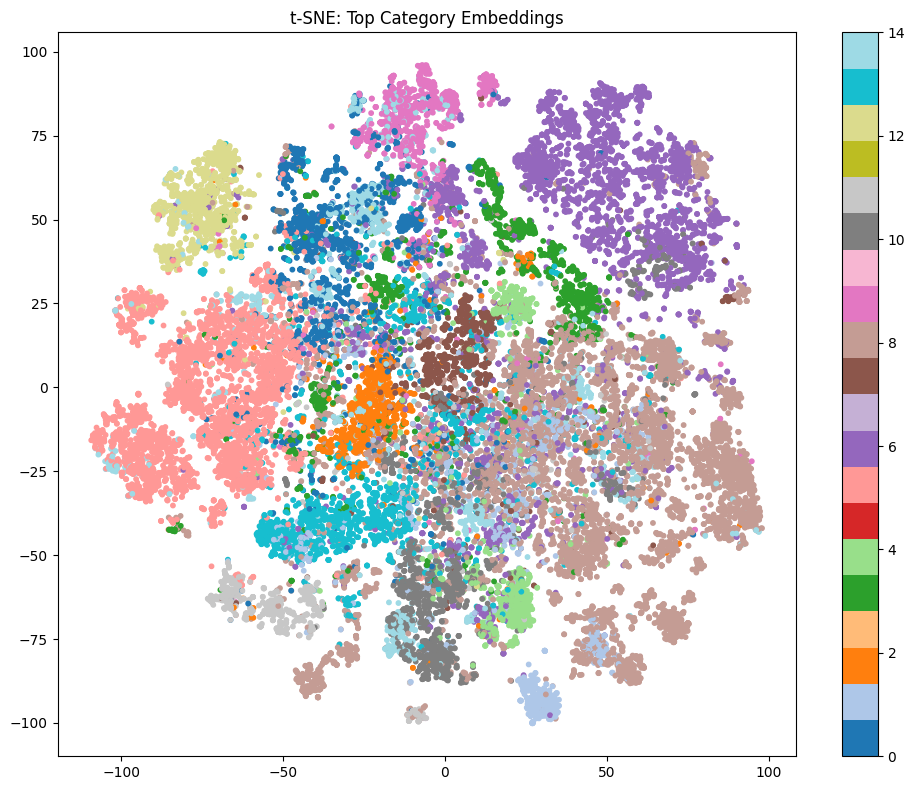

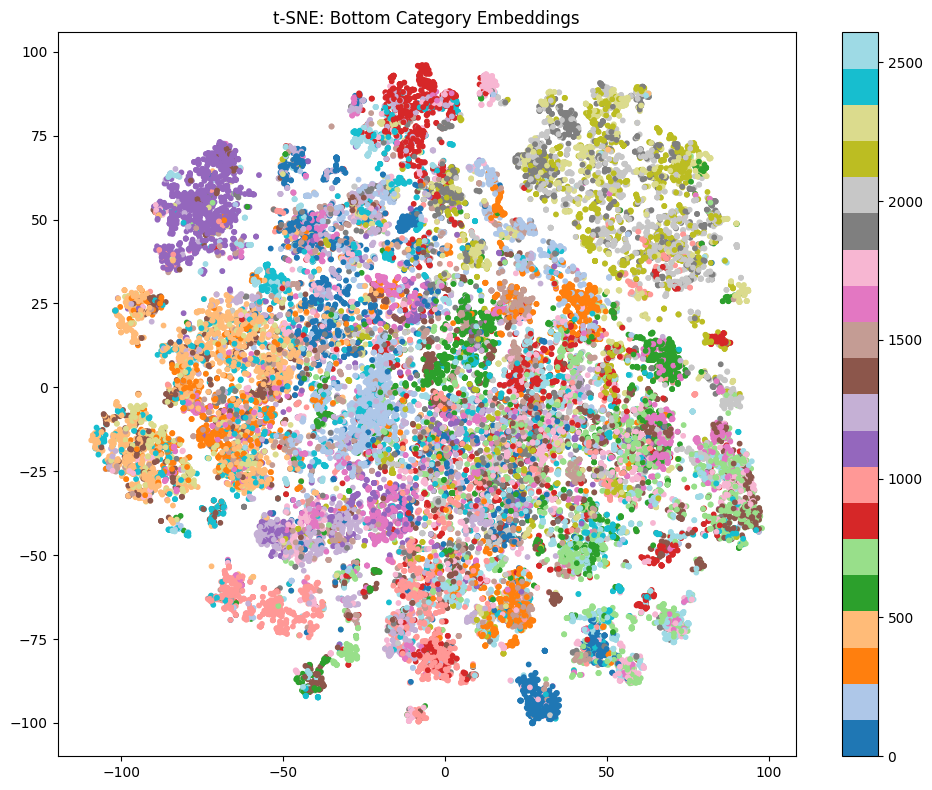

In [23]:
# ========== t-SNE VISUALIZATION ==========

"""
    These clusters provide us with clear evidence that the
    model’s latent space is picking up on high-level category
    differences even before its classification layers.
"""

# Combine all embeddings into one large array
all_embeddings_np = np.concatenate(all_embeddings, axis=0)

# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced = tsne.fit_transform(all_embeddings_np)

# Plotting the reduced 2D embeddings
plt.figure(figsize=(10, 8))

# Color by the top categories to see if similar categories cluster together
plt.scatter(reduced[:, 0], reduced[:, 1], c=all_y_top, cmap='tab20', s=10)
plt.title("t-SNE: Top Category Embeddings")
plt.colorbar()  # Show a color bar to indicate different top categories
plt.tight_layout()
plt.show()

# Optionally: Do the same for the bottom categories
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=all_y_bottom, cmap='tab20', s=10)
plt.title("t-SNE: Bottom Category Embeddings")
plt.colorbar()  # Show a color bar to indicate different bottom categories
plt.tight_layout()
plt.show()
